In [3]:
pip install fairlearn matplotlib


Note: you may need to restart the kernel to use updated packages.


Pandas DataFrame (X):
   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   25  226802              7             0             0              40   
1   38   89814              9             0             0              50   
2   28  336951             12             0             0              40   
3   44  160323             10          7688             0              40   
4   18  103497             10             0             0              30   

   workclass_Federal-gov  workclass_Local-gov  workclass_Never-worked  \
0                  False                False                   False   
1                  False                False                   False   
2                  False                 True                   False   
3                  False                False                   False   
4                  False                False                   False   

   workclass_Private  ...  native-country_Portugal  \
0               True  

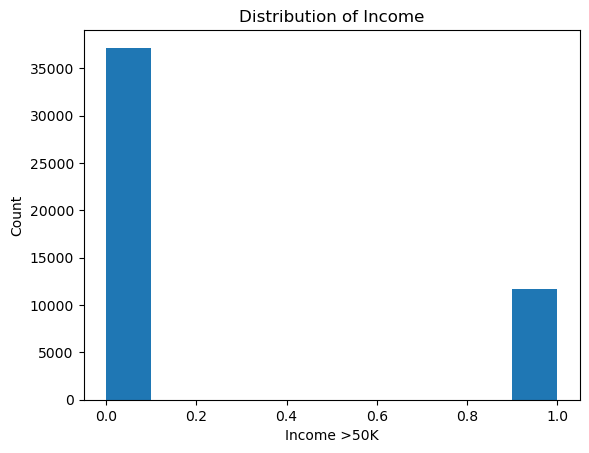

In [1]:
#some testing here by AM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

# Fetch the adult dataset
data = fetch_adult(as_frame=True)

# Convert features to Pandas DataFrame with one-hot encoding
X = pd.get_dummies(data.data)

# Target variable: convert to binary classification ('>50K' as 1, '<=50K' as 0)
y_true = (data.target == '>50K') * 1

# Display the Pandas DataFrame and head
print("Pandas DataFrame (X):")
print(X.head())

# Example visualization (optional)
plt.hist(y_true)
plt.xlabel('Income >50K')
plt.ylabel('Count')
plt.title('Distribution of Income')
plt.show()


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult
data = fetch_adult(as_frame=True)

X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

## Model Bias Detection and Mitigation using Fairlearn
In this example, we'll use the Adult dataset from the UCI Machine Learning Repository to demonstrate how to detect and mitigate model bias. We'll explore bias based on the 'sex' attribute and apply different techniques to address any detected bias. We'll use Fairlearn and other tools for bias detection and mitigation.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

# Load the dataset
data = fetch_adult(as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']

# Check the distribution of the sensitive attribute
print(sex.value_counts())


sex
Male      32650
Female    16192
Name: count, dtype: int64


### Step 1: Load and Prepare the Data


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

# Load the dataset
data = fetch_adult(as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']

# Check the distribution of the sensitive attribute
print(sex.value_counts())


sex
Male      32650
Female    16192
Name: count, dtype: int64


### Step 2: Train Initial Model

We train an initial Logistic Regression model to establish a baseline.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data into train and test sets
X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(X, y_true, sex, test_size=0.3, random_state=0, stratify=y_true)

# Train a Logistic Regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.796901658363475
              precision    recall  f1-score   support

           0       0.80      0.97      0.88     11147
           1       0.71      0.25      0.37      3506

    accuracy                           0.80     14653
   macro avg       0.76      0.61      0.63     14653
weighted avg       0.78      0.80      0.76     14653



### Step 3: Detect Bias using Fairlearn

We'll check for fairness issues using metrics such as demographic parity and equalized odds.

In [19]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Custom wrapper functions for metrics
def demographic_parity_diff(y_true, y_pred, **kwargs):
    return demographic_parity_difference(y_true, y_pred, **kwargs)

def equalized_odds_diff(y_true, y_pred, **kwargs):
    return equalized_odds_difference(y_true, y_pred, **kwargs)

# Calculate fairness metrics
metrics = {
    'accuracy': accuracy_score,
    'demographic_parity_difference': demographic_parity_diff,
    'equalized_odds_difference': equalized_odds_diff
}

# Ensure sensitive features match y_true
y_true_test = y_test.reset_index(drop=True)
sex_test = sex_test.reset_index(drop=True)

metric_frame = MetricFrame(metrics=metrics, y_true=y_true_test, y_pred=y_pred, sensitive_features=sex_test)
print(metric_frame.by_group)


TypeError: demographic_parity_difference() missing 1 required keyword-only argument: 'sensitive_features'

In [ ]:
#Revised Full Code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

# Assuming 'adult.csv' is located in the same directory as your script
file_path = "adult.csv"

# Read CSV file into Pandas DataFrame
X = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print("Pandas DataFrame (X):")
print(X.head())

# Count the number of males and females in the 'Gender' column
gender_counts = X['Gender'].value_counts()
print("\nGender Counts:")
print(gender_counts)

# Extract the target variable
y_true = (X['income'] == '>50K').astype(int)

# Convert categorical columns to numerical using one-hot encoding, excluding 'income' and 'Gender'
X_encoded = pd.get_dummies(X.drop(['income', 'Gender'], axis=1))

# Include the target and 'Gender' columns
X_encoded['income'] = y_true
X_encoded['Gender'] = X['Gender']

# Split the data into train and test sets, stratified by the target variable
X_train, X_test, y_train, y_test = train_test_split(X_encoded.drop('income', axis=1), y_true, test_size=0.3, random_state=0, stratify=y_true)

# Extract the 'Gender' column as the sensitive feature
sex_train = X_train['Gender']
sex_test = X_test['Gender']

# Drop the 'Gender' column from the training and test sets
X_train = X_train.drop('Gender', axis=1)
X_test = X_test.drop('Gender', axis=1)

# Train a Logistic Regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Custom wrapper functions for metrics
def demographic_parity_diff(y_true, y_pred, **kwargs):
    return demographic_parity_difference(y_true, y_pred, **kwargs)

def equalized_odds_diff(y_true, y_pred, **kwargs):
    return equalized_odds_difference(y_true, y_pred, **kwargs)

# Calculate fairness metrics
metrics = {
    'accuracy': accuracy_score,
    'demographic_parity_difference': demographic_parity_diff,
    'equalized_odds_difference': equalized_odds_diff
}

# Ensure sensitive features match y_true
y_true_test = y_test.reset_index(drop=True)
sex_test = sex_test.reset_index(drop=True)

metric_frame = MetricFrame(metrics=metrics, y_true=y_true_test, y_pred=y_pred, sensitive_features=sex_test)
print(metric_frame.by_group)
